# Preparación
Se monta el sistema de archivos de google drive.


In [47]:
import tensorflow as tf
tf.test.gpu_device_name()

2022-01-08 22:22:43.992545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 22:22:43.993319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 22:22:43.993888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 22:22:43.994359: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 22:22:43.994689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

'/device:GPU:0'

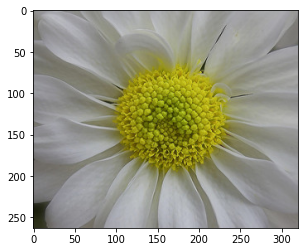

In [48]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('../input/flowers-recognition/flowers/daisy/100080576_f52e8ee070_n.jpg', 'r')
imshow(np.asarray(pil_im))



# Carga del dataset

In [49]:
image_size = (150, 150)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/flowers-recognition/flowers",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/flowers-recognition/flowers",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


# Modelo

In [50]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten, BatchNormalization, GlobalAveragePooling2D

In [51]:
model = keras.Sequential()

model.add(Rescaling(scale=(1./255), input_shape=(150, 150, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides = (2,2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

model.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(5, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])



# Visualización del modelo

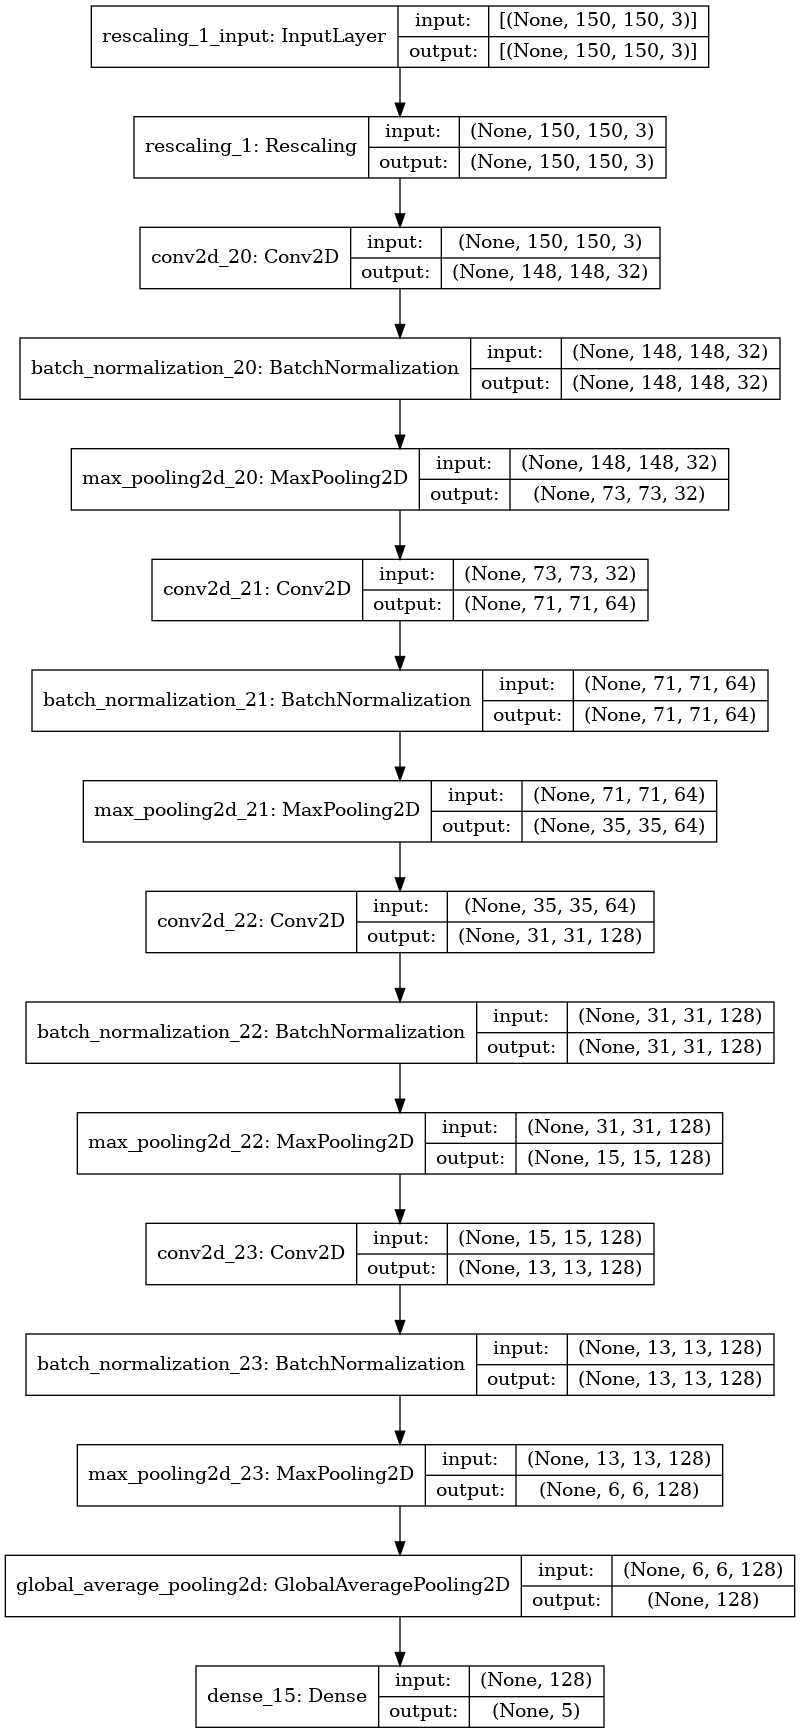

In [52]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True,
           show_layer_names=True)

# Entrenamiento

In [53]:
from keras.callbacks import EarlyStopping

epochs = 150

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10,
                   restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs, 
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/150
108/108 [==============================] - 7s 57ms/step - loss: 1.0674 - accuracy: 0.5869 - val_loss: 2.0465 - val_accuracy: 0.2711
Epoch 2/150
108/108 [==============================] - 7s 58ms/step - loss: 0.8763 - accuracy: 0.6691 - val_loss: 2.0482 - val_accuracy: 0.2723
Epoch 3/150
108/108 [==============================] - 7s 59ms/step - loss: 0.8150 - accuracy: 0.7003 - val_loss: 2.1009 - val_accuracy: 0.3256
Epoch 4/150
108/108 [==============================] - 7s 61ms/step - loss: 0.7264 - accuracy: 0.7293 - val_loss: 1.2442 - val_accuracy: 0.4844
Epoch 5/150
108/108 [==============================] - 7s 57ms/step - loss: 0.6926 - accuracy: 0.7377 - val_loss: 1.1636 - val_accuracy: 0.5736
Epoch 6/150
108/108 [==============================] - 7s 57ms/step - loss: 0.6318 - accuracy: 0.7609 - val_loss: 1.4120 - val_accuracy: 0.4809
Epoch 7/150
108/108 [==============================] - 7s 61ms/step - loss: 0.6015 - accuracy: 0.7768 - val_loss: 1.1032 - val_accuracy:

# Gráfica de evolución de pérdida y exactitud durante el entrenamiento

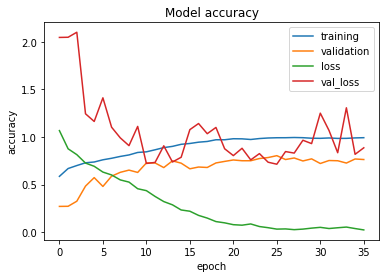

In [54]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss', 'val_loss'], loc='upper right')
plt.show()

# Evaluación de los resultados

              precision    recall  f1-score   support

           0     0.7299    0.8475    0.7843       118
           1     0.8462    0.8646    0.8553       229
           2     0.7748    0.6882    0.7290       170
           3     0.9267    0.7898    0.8528       176
           4     0.7330    0.8235    0.7756       170

    accuracy                         0.8042       863
   macro avg     0.8021    0.8027    0.7994       863
weighted avg     0.8103    0.8042    0.8045       863



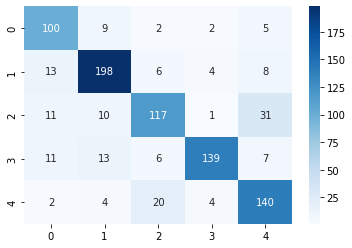

In [55]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

In [56]:
img = keras.preprocessing.image.load_img(
    '../input/flowers-recognition/flowers/daisy/10172636503_21bededa75_n.jpg', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(np.argmax(predictions[0]))

0
